In [1]:
import os
import pandas as pd
import scanpy as sc
import seaborn as sns 
import matplotlib.pyplot as plt

# To be deleted (prepare tutorial dataset)

In [4]:
DIR_BAM = '/node200data/18parkky/datasets/data/public/BAM/Kinker_et_al'
metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Kinker_et_al/Metadata.txt', sep='\t')
metadata

/tmp/ipykernel_147982/3404475923.py:2: DtypeWarning: Columns (4,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Kinker_et_al/Metadata.txt', sep='\t')


,_NAME,Cell_line,Pool_ID,Cancer_type,Genes_expressed,Discrete_cluster_minpts5_eps1.8,Discrete_cluster_minpts5_eps1.5,Discrete_cluster_minpts5_eps1.2,CNA_subclone,SkinPig_score,...,EMTII_score,EMTIII_score,IFNResp_score,p53Sen_score,EpiSen_score,StressResp_score,ProtMatu_score,ProtDegra_score,G1/S_score,G2/M_score
0,TYPE,group,group,group,numeric,group,group,group,group,numeric,...,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric
1,AAACCTGAGACATAAC-1-18,NCIH2126_LUNG,18,Lung Cancer,4318,NaN,NaN,NaN,NaN,0.166,...,-0.935,-0.935,0.13,0.619,1.869,-0.004,0.805,0.896,0.424,-1.125
2,AACGTTGTCACCCGAG-1-18,NCIH2126_LUNG,18,Lung Cancer,5200,NaN,NaN,NaN,NaN,-0.213,...,-1.027,-1.027,0.066,1.049,1.267,0.252,1.299,1.61,0.624,-0.048
3,AACTGGTAGACACGAC-1-18,NCIH2126_LUNG,18,Lung Cancer,4004,NaN,NaN,NaN,NaN,-0.101,...,-0.677,-0.677,0.304,0.822,2.401,0.141,0.451,1.225,-0.795,0.064
4,AACTGGTAGGGCTTGA-1-18,NCIH2126_LUNG,18,Lung Cancer,4295,NaN,NaN,NaN,NaN,-0.014,...,-0.735,-0.735,0.094,0.834,2.282,0.15,0.267,0.892,-0.238,1.118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53509,c4722,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,3343,NaN,NaN,NaN,NaN,0.018,...,-0.505,-0.505,1.657,1.583,3.85,0.539,0.473,0.544,-1.079,-1.349
53510,c4724,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,6977,NaN,NaN,NaN,NaN,-0.098,...,-0.876,-0.876,0.669,1.086,3.046,0.799,0.49,1.319,-0.37,0.057
53511,c4731,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,6638,NaN,NaN,NaN,NaN,-0.112,...,-0.112,-0.112,0.61,0.693,2.289,0.65,0.729,1.143,-0.508,0.501
53512,c4735,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,4052,NaN,NaN,NaN,NaN,-0.244,...,1.981,1.981,0.523,-0.309,0.267,0.822,1.049,0.777,0.296,-0.936


In [ ]:
''' 
MSI : CCK81, HEC151
MSS : LS1034, HCC56
'''

In [12]:
metadata_oi = metadata[(metadata['Cell_line'].isin( ['CCK81_LARGE_INTESTINE', 'HEC151_ENDOMETRIUM', 'HCC56_LARGE_INTESTINE', 'LS1034_LARGE_INTESTINE'] ))].copy()
metadata_oi['CB'] = [ entry.split('-')[0] for entry in metadata_oi['_NAME'] ]
metadata_oi['num_pair'] = [ '_'.join(entry.split('-')[1:]) for entry in metadata_oi['_NAME'] ]
metadata_oi.head(2)

,_NAME,Cell_line,Pool_ID,Cancer_type,Genes_expressed,Discrete_cluster_minpts5_eps1.8,Discrete_cluster_minpts5_eps1.5,Discrete_cluster_minpts5_eps1.2,CNA_subclone,SkinPig_score,...,IFNResp_score,p53Sen_score,EpiSen_score,StressResp_score,ProtMatu_score,ProtDegra_score,G1/S_score,G2/M_score,CB,num_pair
6955,AAACCTGGTTTGTTTC-3-22,LS1034_LARGE_INTESTINE,22,Colon/Colorectal Cancer,2379,NaN,NaN,NaN,NaN,0.415,...,0.23,1.704,0.733,0.06,-0.468,-0.479,-0.902,-0.688,AAACCTGGTTTGTTTC,3_22
6956,AACACGTTCGTTTGCC-3-22,LS1034_LARGE_INTESTINE,22,Colon/Colorectal Cancer,3280,NaN,NaN,NaN,NaN,0.066,...,-0.227,0.136,0.174,0.007,0.035,0.339,-0.594,1.02,AACACGTTCGTTTGCC,3_22


In [15]:
for num_pair, edf in metadata_oi.groupby('num_pair'):
    whitelist = set(edf['CB'])
    print(f'{num_pair}\t{len(whitelist)}')
    PATH_bamfile_out = f'/home/18parkky/git/scMnT/tutorial/{num_pair}.bam'
    PATH_bamfile = f'{DIR_BAM}/Pool{num_pair}.possorted_genome.bam'
    bamfile = pysam.AlignmentFile(PATH_bamfile, 'rb')
    bamfile_new = pysam.AlignmentFile(PATH_bamfile_out, 'wb', template=bamfile)
    
    for read in bamfile.fetch():
        try:
            CB = read.get_tag('CB').split('-')[0]
        except: continue 
        
        if CB in whitelist:
            bamfile_new.write(read)
    bamfile_new.close()

13_15	179
14_15	170
3_22	75
4_22	71
7_16	60
8_16	67


In [17]:
adata = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Kinker_et_al/CPM_data.scanpy_preprocessed.CRC-GC-EC.h5ad')


In [28]:
adata_oi = adata[(adata.obs['CellLine'].isin( ['CCK81_LARGE_INTESTINE', 'HEC151_ENDOMETRIUM', 'HCC56_LARGE_INTESTINE', 'LS1034_LARGE_INTESTINE'] ))].copy()
adata_oi = adata_oi.raw.to_adata()

sc.pp.highly_variable_genes(adata_oi, n_top_genes=2000, batch_key='PoolID')

sc.pp.scale(adata_oi, max_value=10)
sc.tl.pca(adata_oi, svd_solver="arpack")

sc.pp.neighbors(adata_oi, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_oi, random_state=42)

CellLine_to_CellType = {
    'LS1034_LARGE_INTESTINE' : 'MSS - LS1034_LARGE_INTESTINE',  # Reference
    'CCK81_LARGE_INTESTINE' : 'Tumor - CCK81_LARGE_INTESTINE',  # Query 1
    'HEC151_ENDOMETRIUM' : 'Tumor - HEC151_ENDOMETRIUM',        # Query 2
    'HCC56_LARGE_INTESTINE' : 'Tumor - HCC56_LARGE_INTESTINE'   # Query 3
}

adata_oi.obs['CellType'] = [ CellLine_to_CellType[CellLine] for CellLine in adata_oi.obs['CellLine'] ]

/home/18parkky/miniforge3/envs/sc_mamba/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [107]:
adata_oi.write('data/adata.h5ad')

NameError: name 'adata_oi' is not defined

# Run scMnT

In [ ]:
""" 
In this demo notebook, we analyze a subset of scRNA-seq data from Kinker et al. (https://doi.org/10.1038/s41588-020-00726-6).
Four cancer cell lines are included in this analysis—two microsatellite stable (MSS) and two microsatellite instable (MSI). 
For demonstration purposes, we assume that the MSI status of only one cell line, LS1034 (MSS), is known, while the statuses of the remaining three (CCK81, HEC151, and HCC56) are unknown.
    
    LS1034_LARGE_INTESTINE  MSS     Reference
    HCC56_LARGE_INTESTINE   MSS     Query 1
    CCK81_LARGE_INTESTINE   MSI     Query 2
    HEC151_ENDOMETRIUM      MSI     Query 3
    
All files required to run this demo are available on Zenodo (https://zenodo.org/records/17306384) and on the scMnT GitHub respoitory. 
"""

## Download data

In [ ]:
""" 
scMnT requires the following files:
    
    [ Available from Zenodo ]
        1) Scanpy object (h5ad) that has cell type labeled under .obs['CellType']
        2) BAM file of raw sequencing reads, where reads are tagged with CB and UB (reads without CB/UB may be present)
    [ Available from scMNT GitHub repository ]
        3) Microsatellite loci table (generated by Krait, availble at ~/scMnT/ref/GRCh38-1bp_STR.tsv.gz)
    [ Download from other sources (e.g., NCBI or GENCODE) ] 
        4) Reference genome (e.g., GRCh38.fa)
"""

In [2]:
DIR_data = f'{os.getcwd()}/data'
if os.path.exists(DIR_data)==False: os.mkdir(DIR_data)

In [12]:
# Scanpy object
url = 'https://zenodo.org/records/17306384/files/adata.h5ad?download=1'
filename = 'adata.h5ad'
print(f'Downloading {filename}')
!wget "{url}" -O {DIR_data}/{filename}

# BAM file
url = 'https://zenodo.org/records/17306384/files/kinker_et_al.bam?download=1'
filename = 'kinker_et_al.bam'
print(f'Downloading {filename}')
!wget "{url}" -O {DIR_data}/{filename}

# BAM index file
url = 'https://zenodo.org/records/17306384/files/kinker_et_al.bam.bai?download=1'
filename = 'kinker_et_al.bam.bai'
print(f'Downloading {filename}')
!wget "{url}" -O {DIR_data}/{filename}

# Loci table
url = 'https://github.com/18parkky/scMnT/raw/main/ref/total/GRCh38-1bp_STR.tsv.gz'
filename = 'GRCh38-1bp_STR.tsv.gz'
print(f'Downloading {filename}')
!wget "{url}" -O {DIR_data}/{filename}

# Reference genome
url = 'https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_49/GRCh38.primary_assembly.genome.fa.gz'
filename = 'GRCh38.primary_assembly.genome.fa.gz'
print(f'Downloading {filename}')
!wget "{url}" -O {DIR_data}/{filename}
# Pysam requires FASTA files to be decompressed
!gzip -d {DIR_data}/{filename}

--2025-10-10 23:32:55--  https://zenodo.org/records/17306384/files/adata.h5ad?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119639734 (114M) [application/octet-stream]
Saving to: ‘/home/18parkky/git/scMnT/tutorial/data/adata.h5ad’

100%[======================================>] 119,639,734  319KB/s   in 5m 54s 

2025-10-10 23:38:51 (330 KB/s) - ‘/home/18parkky/git/scMnT/tutorial/data/adata.h5ad’ saved [119639734/119639734]

--2025-10-10 23:38:51--  https://zenodo.org/records/17306384/files/kinker_et_al.bam?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1817157871 (1.7G) [application/octet-stream]
Saving to: ‘/home/18parkky/git/scMnT/tut

622


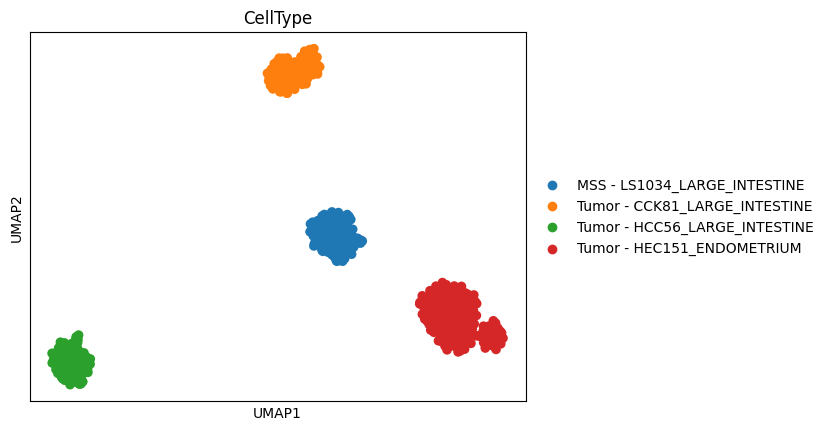

In [13]:
"""
As we can see below, 4 clusters each representing a single cancer cell line. The LS1034 cell line cells will be used as the 'normal' cells.
"""
adata = sc.read_h5ad(f'{DIR_data}/adata.h5ad')
print(len(adata))
sc.pl.umap(adata, color=['CellType'])

## Run scMnT

In [14]:
threads = 16 # Adjust accordingly

In [16]:
# Takes ~16 minutes in our system using 16 threads
cmd = f'scMnT -a {DIR_data}/adata.h5ad ' \
        f'-b {DIR_data}/kinker_et_al.bam ' \
        f'-s {DIR_data}/GRCh38-1bp_STR.tsv.gz ' \
        f'-r {DIR_data}/GRCh38.primary_assembly.genome.fa ' \
        f'-n kinker_et_al_tutorial ' \
        f'-t {threads}'
!{cmd}

/home/18parkky/miniforge3/envs/scmnt/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# Downstream analysis

In [17]:
adata_scMnT = sc.read_h5ad('kinker_et_al_tutorial.scMnT.h5ad')

## Rough inspection of MSI score between cell lines

<Axes: xlabel='NumSTRLoci', ylabel='Count'>

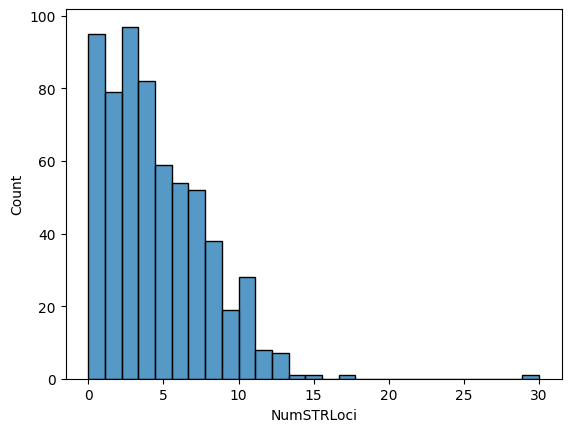

In [18]:
"""
Most cells exhibit less than 5 supporting reads that align to MS loci, but this is enough to infer MSI status
"""
sns.histplot(data=adata_scMnT.obs, x='NumSTRLoci')

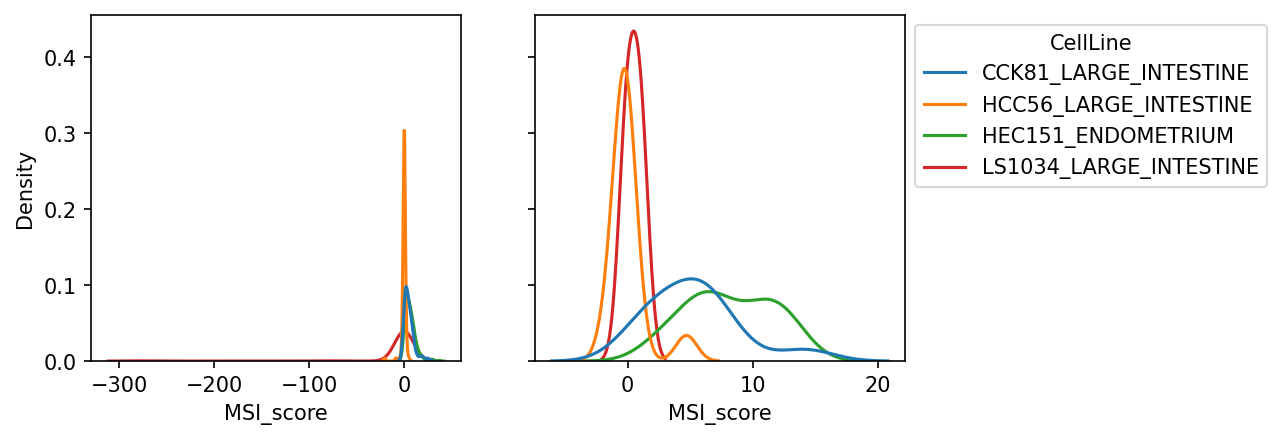

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3), dpi=150, sharey=True,)
ax1 = sns.kdeplot(data=adata_scMnT.obs[(adata_scMnT.obs['NumSTRLoci']>0)], hue='CellLine', x='MSI_score', ax=axes[0], common_norm=False, legend=None,)
ax2 = sns.kdeplot(data=adata_scMnT.obs[(adata_scMnT.obs['NumSTRLoci']>=10)], hue='CellLine', x='MSI_score', ax=axes[1], common_norm=False, legend=True,)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))

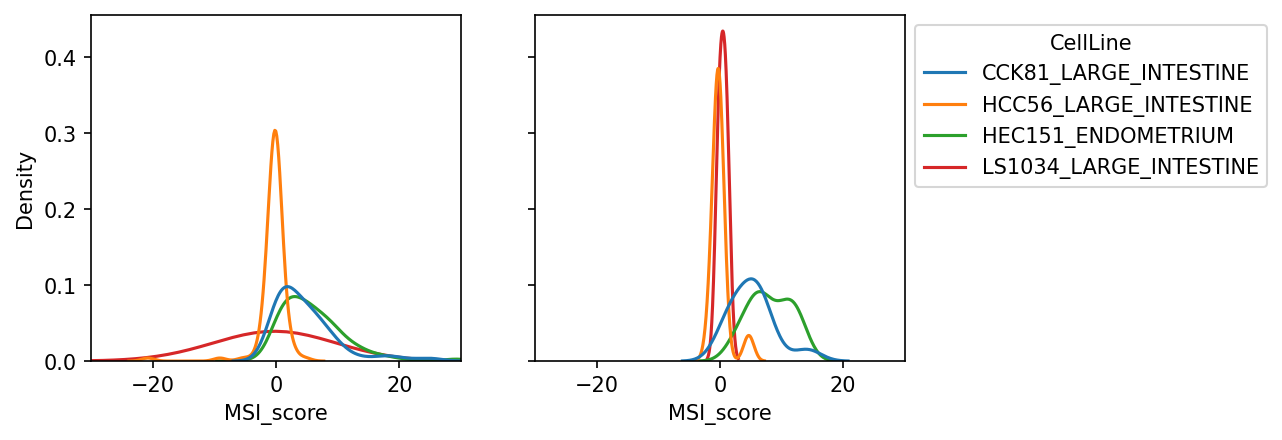

In [20]:
""" 
In the kdeplot above, we see that very few outliers of LS1034 cells stretch the plot excessively to the negative size.
Let's limit the x-axis values to -30~30.
"""

fig, axes = plt.subplots(1, 2, figsize=(7, 3), dpi=150, sharey=True, )
ax1 = sns.kdeplot(data=adata_scMnT.obs[(adata_scMnT.obs['NumSTRLoci']>0)], hue='CellLine', x='MSI_score', ax=axes[0], common_norm=False, legend=None,)
ax2 = sns.kdeplot(data=adata_scMnT.obs[(adata_scMnT.obs['NumSTRLoci']>=10)], hue='CellLine', x='MSI_score', ax=axes[1], common_norm=False, legend=True,)
ax1.set_xlim([-30, 30]);
ax2.set_xlim([-30, 30]);
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))

## UMAP visualization of MSI score

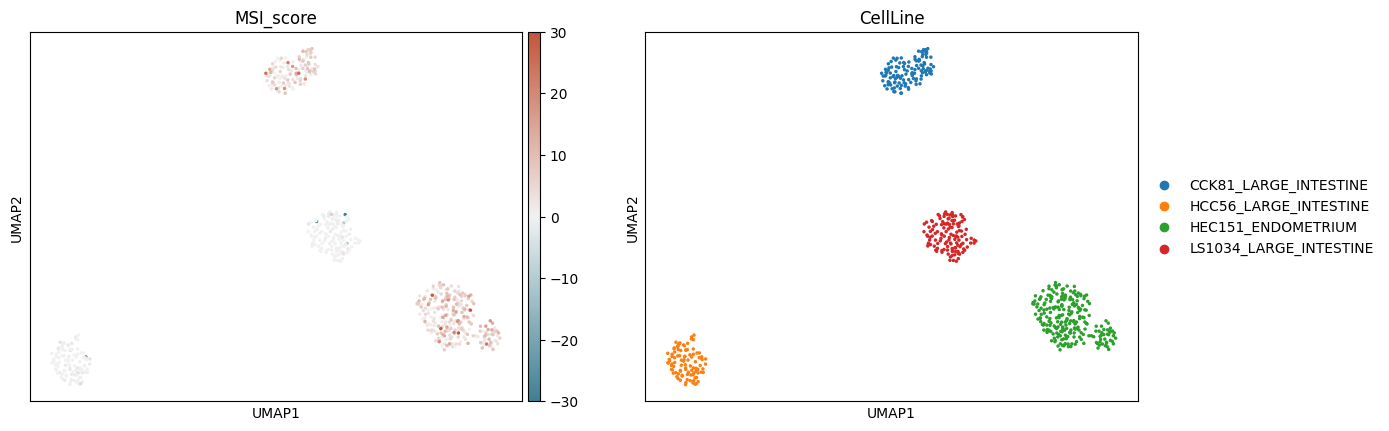

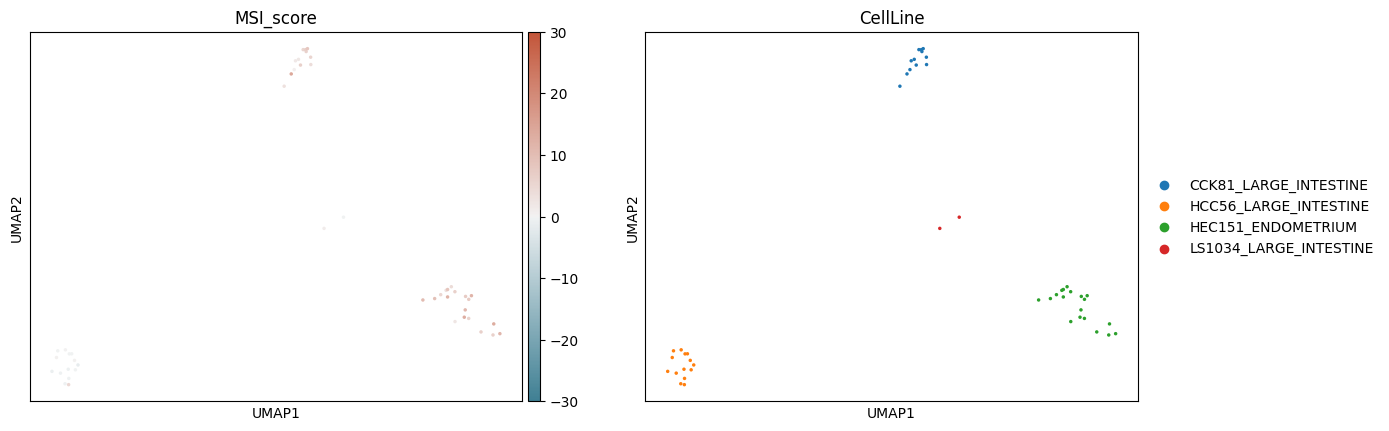

In [21]:
""" 
As we can see below, only CCK81 and HEC151 cells overall show red colors whereas LS1034 or HCC56 cells show white colors.
This aligns well with the actual MSI status of the cell lines.
"""

sc.pl.umap(adata_scMnT[(adata_scMnT.obs['NumSTRLoci']>0)], color=['MSI_score', 'CellLine'], 
           vmin=-30, vmax=30, 
           cmap=sns.diverging_palette(220, 20, as_cmap=True),
           s=25, 
           )

sc.pl.umap(adata_scMnT[(adata_scMnT.obs['NumSTRLoci']>=10)], color=['MSI_score', 'CellLine'], 
           vmin=-30, vmax=30, 
           cmap=sns.diverging_palette(220, 20, as_cmap=True),
           s=25, 
           )

## Statistics test results (results of scMnT-find)

[2, 2, 2]


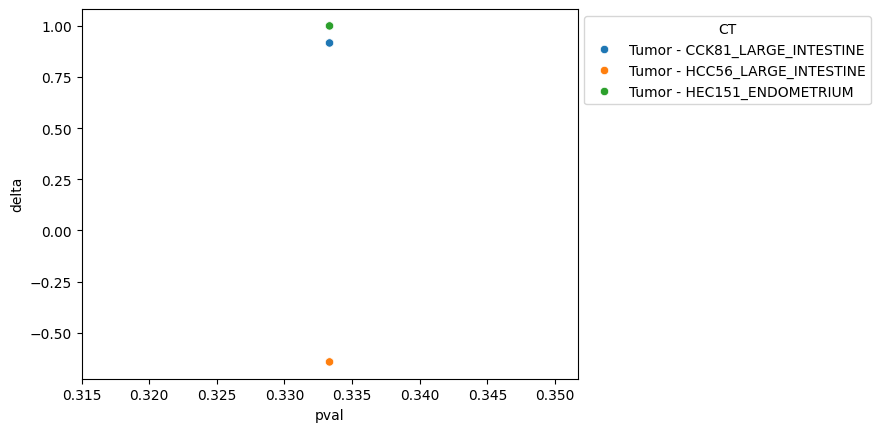

In [22]:
"""  
scMnT performs Kolmogorov-Smirnov test and compares MSI score distribution of user-specified cell types (cell types whose name starts with 'Tumor') against reference cell types (all other cell types).
As shown below, unfortunately, while the delta values well segrate the MSI cells (i.e., HEC151 and CCK81) from the MSS cells (HCC56), the p-values of the test is ~0.33 due to the small number of testing cells.
Let's re-do the test using a more lenient threshold for minimum number of microsatellite loci. 
"""

scMnT_test_results = pd.read_csv('kinker_et_al_tutorial.findMSI_results.tsv', sep='\t')
ax = sns.scatterplot(data=scMnT_test_results, x='pval', y='delta', hue='CT')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
print(list(scMnT_test_results['n_cells']))  # Only 2 cells per cell type was used for Kolmogorov-Smirnov test, which explains the high p-value.

In [23]:
cmd = 'scMnT-find -a kinker_et_al_tutorial.scMnT.h5ad -n kinker_et_al_tutorial_lenient -m 5'
!{cmd}

[29, 29, 29]


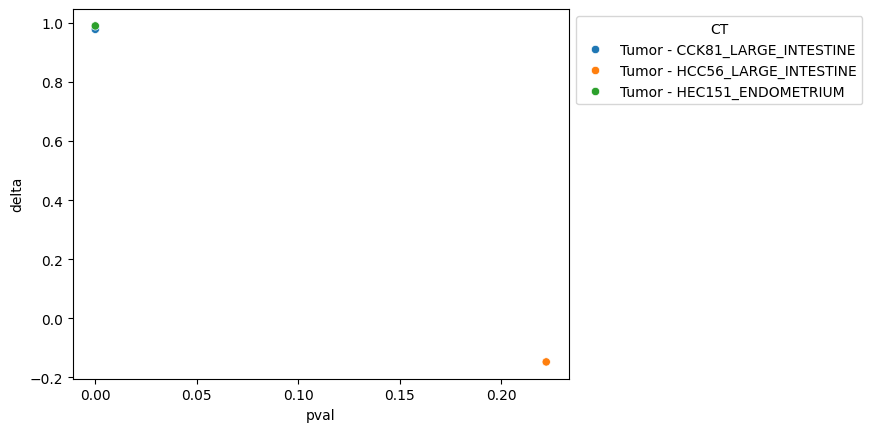

In [25]:
"""  
The lenient test has clearly separated the MSI cells from MSS cells.
"""

scMnT_test_results = pd.read_csv('kinker_et_al_tutorial_lenient.findMSI_results.tsv', sep='\t')
ax = sns.scatterplot(data=scMnT_test_results, x='pval', y='delta', hue='CT')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
print(list(scMnT_test_results['n_cells']))  # Increased from 2 to 29 cells